<a href="https://colab.research.google.com/github/haniehghaffari/Deep_learning/blob/main/RegUNet_moni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  i_use_https://github.com/DeepRegNet/DeepReg/blob/main/deepreg/model/backbone/local_net.py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 583kB 7.6MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 


In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)
from monai.networks.nets import UNet
# from monai.networks.nets import RegUNet
from monai.networks.layers import Norm
from monai.metrics import compute_meandice
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

MONAI version: 0.6.dev2127
Numpy version: 1.19.5
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 889f33577be13b590211663995d2285aafc8fd74

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.5.0
gdown version: 3.6.4
TorchVision version: 0.10.0+cu102
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.61.2
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpoi_2vssg


In [ ]:
from glob import glob as gg
train_labels =[]

path ='/content/drive/MyDrive/H&M/ConvertedToNii/gtvt/'
classes =os.listdir(path)
# print(classes)
# print(len(classes))


for cls in files:
  label =gg(path + cls +'/*.nii.gz')
  # print(label)
  # for lbl in label :
    # print('ok')
  train_labels.append(label)
   
# train_labels

In [ ]:
train_images =[]

path ='/content/drive/MyDrive/H&M/ConvertedToNii/ct/'
classes =os.listdir(path)
# print(classes)



for cls in files:
  images =gg(path + cls +'/*.nii.gz')
  # print(images)
  # for img in images :
    # print('ok')
  train_images.append(images)
    # gtvt.append(cls)
# len(train_images)

In [ ]:
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
for i in data_dicts: 
  if (i['image'] == []):
    data_dicts.remove(i)
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [ ]:
train_files[5]

{'image': ['/content/drive/MyDrive/H&M/ConvertedToNii/ct/103/3_merged.nii.gz'],
 'label': ['/content/drive/MyDrive/H&M/ConvertedToNii/gtvt/103/103.nii.gz']}

In [ ]:
set_determinism(seed=0)

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

In [ ]:
# check_ds = Dataset(data=val_files, transform=val_transforms)
# check_loader = DataLoader(check_ds, batch_size=1)
# check_data = first(check_loader)
# image, label = (check_data["image"][0][0], check_data["label"][0][0])
# print(f"image shape: {image.shape}, label shape: {label.shape}")
# # plot the slice [:, :, 80]
# plt.figure("check", (12, 6))
# plt.subplot(1, 2, 1)
# plt.title("image")
# plt.imshow(image[:, :, 80], cmap="gray")
# plt.subplot(1, 2, 2)
# plt.title("label")
# plt.imshow(label[:, :, 80])
# plt.show()

In [ ]:
train_ds = CacheDataset(
    data=train_files[40:60], transform=train_transforms,
    cache_rate=1.0, num_workers=2)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)

val_ds = CacheDataset(
    data=val_files[10:16], transform=val_transforms, cache_rate=1.0, num_workers=2)#6-10#10-16#16-22#
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 20/20 [01:26<00:00,  4.33s/it]


In [ ]:
%%time
import torch
torch.cuda.is_available()

CPU times: user 4.03 ms, sys: 28.8 ms, total: 32.9 ms
Wall time: 55.8 ms


In [ ]:
from monai.networks.nets import RegUNet


device = torch.device("cuda:0")

ddir ="/content/drive/MyDrive/H&M/Hanieh/RUn/regunet/model2_weights.pth"
model = torch.load((ddir))

model = model.to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

In [ ]:
max_epochs = 100
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)
post_label = AsDiscrete(to_onehot=True, n_classes=2)

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = post_pred(val_outputs)
                val_labels = post_label(val_labels)
                value = compute_meandice(
                    y_pred=val_outputs,
                    y=val_labels,
                    include_background=False,
                )
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/100
1/10, train_loss: 0.5704
2/10, train_loss: 0.5675
3/10, train_loss: 0.5634
4/10, train_loss: 0.5661
5/10, train_loss: 0.5644
6/10, train_loss: 0.5624
7/10, train_loss: 0.5619
8/10, train_loss: 0.5580
9/10, train_loss: 0.5584
10/10, train_loss: 0.5577
epoch 1 average loss: 0.5630
----------
epoch 2/100
1/10, train_loss: 0.5582
2/10, train_loss: 0.5544
3/10, train_loss: 0.5549
4/10, train_loss: 0.5509
5/10, train_loss: 0.5493
6/10, train_loss: 0.5513
7/10, train_loss: 0.5486
8/10, train_loss: 0.5452
9/10, train_loss: 0.5462
10/10, train_loss: 0.5442
epoch 2 average loss: 0.5503


ZeroDivisionError: ignored

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.5000 at epoch: 2


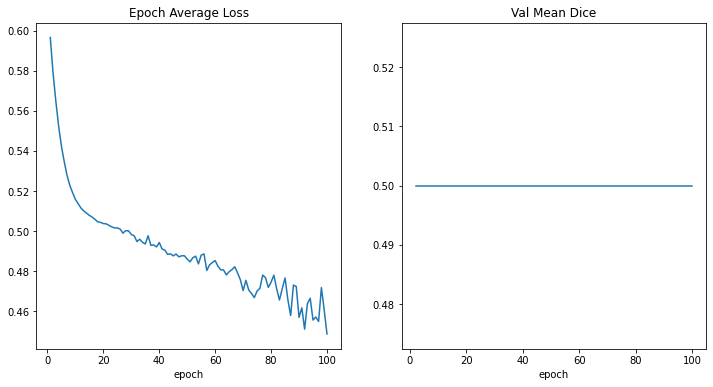

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

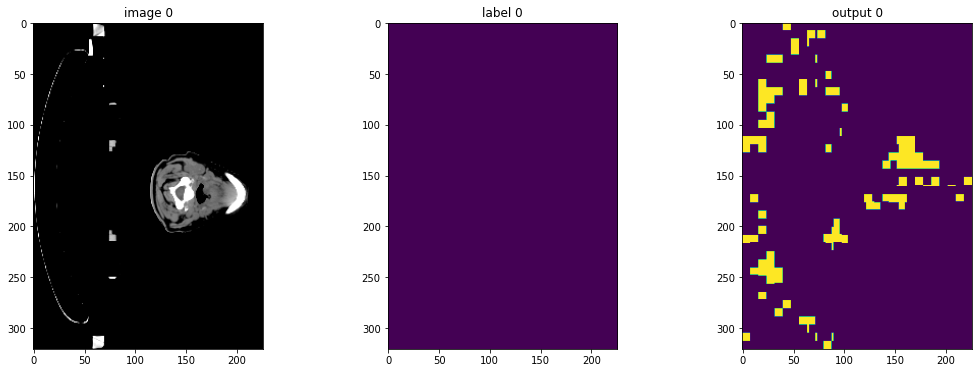

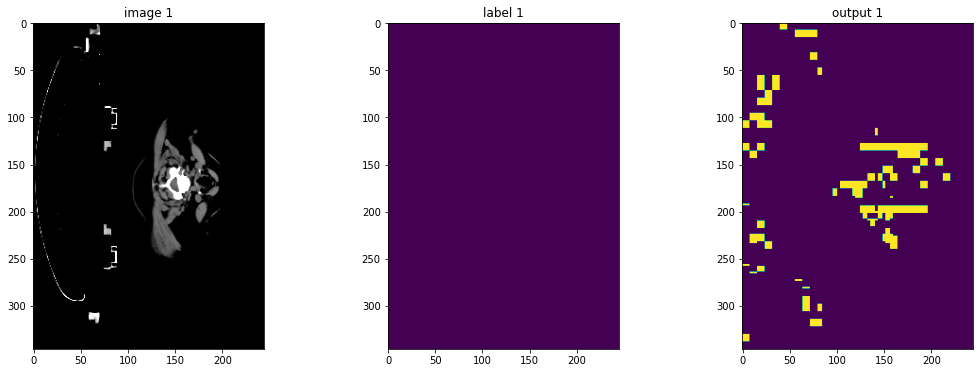

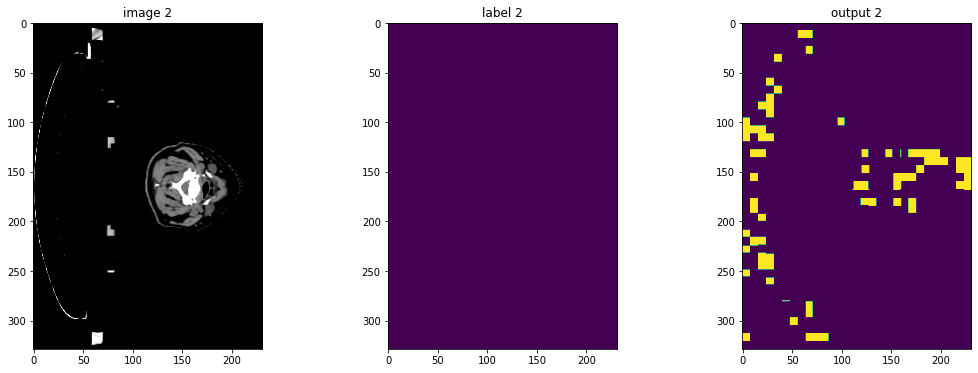

In [ ]:
import nibabel as nib
import numpy as np
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # o = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, :]
        # o = np.array(o)
        # v = nib.load(val_files[i]["label"])
        # ni_img = nib.Nifti1Image(o, v.affine)
        # #name= (val_files[i]["label"].split("/"))[-1].split("_")[0]
        # nib.save(ni_img, '/content/gdrive/MyDrive/H&M/Hanieh/RUn/regunet/'+(val_files[i]["label"].split("/"))[-1].split("_")[0]+'_output.nii.gz')
        # plot the slice [:, :, 80]
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()

In [ ]:
# (val_files[i]["label"].split("/"))[-1].split("_")[0]+'output.nii.gz'

'CHGJ032output.nii.gz'

In [ ]:
# val_data["label"]

In [ ]:
val_outputs

tensor([[[[[-0.1085, -0.1085, -0.1085,  ..., -0.2360, -0.2360, -0.2360],
           [-0.1085, -0.1085, -0.1085,  ..., -0.2360, -0.2360, -0.2360],
           [-0.1085, -0.1085, -0.1085,  ..., -0.2360, -0.2360, -0.2360],
           ...,
           [ 0.7908,  0.7908,  0.7908,  ...,  0.0916,  0.0916,  0.0916],
           [ 0.7908,  0.7908,  0.7908,  ...,  0.0916,  0.0916,  0.0916],
           [ 0.7908,  0.7908,  0.7908,  ...,  0.0916,  0.0916,  0.0916]],

          [[-0.1085, -0.1085, -0.1085,  ..., -0.2360, -0.2360, -0.2360],
           [-0.1085, -0.1085, -0.1085,  ..., -0.2360, -0.2360, -0.2360],
           [-0.1085, -0.1085, -0.1085,  ..., -0.2360, -0.2360, -0.2360],
           ...,
           [ 0.7908,  0.7908,  0.7908,  ...,  0.0916,  0.0916,  0.0916],
           [ 0.7908,  0.7908,  0.7908,  ...,  0.0916,  0.0916,  0.0916],
           [ 0.7908,  0.7908,  0.7908,  ...,  0.0916,  0.0916,  0.0916]],

          [[-0.1085, -0.1085, -0.1085,  ..., -0.2360, -0.2360, -0.2360],
           [-0.

In [ ]:
ddir = "/content/drive/MyDrive/H&M/Hanieh/RUn/regunet/model2_weights.pth"
torch.save(model, ddir)